In [792]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.layers import Dropout

In [793]:
# Pricing data of NVDA
pricing_data = web.DataReader("NVDA", "yahoo", start = "2022-07-01")

# Importing VIX and oil futures prices as part of the parameter
vix_price = web.DataReader("^VIX", "yahoo" , start = "2022-07-01")
wti_price = web.DataReader("CL=F", "yahoo" , start = "2022-07-01")
qqq_price = web.DataReader("QQQ", "yahoo", start = "2022-07-01")

NVDA_closing_price = pd.DataFrame(pricing_data["Close"])
NVDA_volume = pd.DataFrame(pricing_data["Volume"])
vix_closing_price = pd.DataFrame(vix_price["Close"])
wti_closing_price = pd.DataFrame(wti_price["Close"])
qqq_closing_price = pd.DataFrame(qqq_price["Close"])

In [794]:
# RSI function
def rsi(df, periods):
    price_diff = df.diff()
    # up / down value
    up = price_diff.clip(lower=0)
    down = -1 * price_diff.clip(upper=0)
    
    # Avg up / Avg down values (SMA)
    ma_up = up.rolling(window = periods).mean()
    ma_down = down.rolling(window = periods).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

# MACD Function
def macd(df, short_period, long_period, signal_line_period):
    
    short_ewma = df.ewm(span = short_period).mean()
    long_ewma = df.ewm(span = long_period).mean()
    macd = long_ewma - short_ewma
    signal_line = macd.ewm(span = signal_line_period).mean()
    
    return macd, signal_line

In [795]:
# Putting all the covariates into a dataframe
nvda_rsi = pd.DataFrame(rsi(pricing_data["Close"], periods = 14))
nvda_macd, nvda_signal_line =  macd(pricing_data["Close"], short_period = 12, long_period = 26, signal_line_period = 9)
nvda_macd = pd.DataFrame(nvda_macd)
nvda_signal_line = pd.DataFrame(nvda_signal_line)

In [796]:
# Splitting x_data 
x_data = pd.concat([NVDA_volume, vix_closing_price, wti_closing_price, qqq_closing_price, nvda_rsi, nvda_macd, nvda_signal_line], axis = 1)
x_data.columns = ["NVDA_volume", "vix_closing_price", "wti_closing_price", "qqq_closing_price", "NVDA_rsi", "NVDA_macd", "NAVD_signal_line"]


In [797]:
x_data

,NVDA_volume,vix_closing_price,wti_closing_price,qqq_closing_price,NVDA_rsi,NVDA_macd,NAVD_signal_line
Date,,,,,,,
2017-06-30,73106000.0,11.180000,46.040001,137.639999,NaN,0.000000,0.000000
2017-07-03,70907200.0,11.220000,47.070000,136.190002,NaN,0.029335,0.016297
2017-07-05,82018800.0,11.070000,45.130001,137.529999,NaN,0.008539,0.013118
2017-07-06,74628400.0,12.540000,45.520000,136.289993,NaN,-0.005009,0.006977
2017-07-07,65497200.0,11.190000,44.230000,137.759995,NaN,-0.044896,-0.008454
...,...,...,...,...,...,...,...
2022-10-17,58077400.0,31.370001,85.459999,269.350006,45.272825,7.218700,7.620366
2022-10-18,65936200.0,30.500000,82.820000,271.480011,42.757579,6.761158,7.448524
2022-10-19,52313100.0,30.760000,85.550003,270.489990,48.267383,6.258626,7.210545


In [798]:
# Splitting y_data 
y_data = pricing_data["Close"]
y_data

Date
2017-06-30     36.139999
2017-07-03     34.832500
2017-07-05     35.762501
2017-07-06     35.869999
2017-07-07     36.689999
                 ...    
2022-10-17    118.879997
2022-10-18    119.669998
2022-10-19    120.510002
2022-10-20    121.940002
2022-10-21    124.660004
Name: Close, Length: 1338, dtype: float64

In [799]:
# Removing the first few rows which has NA values due to the calculation of RSI and MACD 
total_data = pd.concat([x_data, y_data],axis = 1)
total_data = total_data.dropna()

x_data = total_data[["NVDA_volume", "vix_closing_price", "wti_closing_price", "NVDA_rsi", "NVDA_macd", "NAVD_signal_line"]]
y_data = total_data["Close"]

In [800]:
# This cell is to split training and testing data, will comment out when training for the final model to predict

# x_train, x_test = pd.Series(train_test_split(x_data.dropna(), test_size = 0.20, random_state = None, shuffle = False))
# y_train, y_test = pd.Series(train_test_split(y_data.dropna(), test_size = 0.20, random_state = None, shuffle = False))

# Final model, testing data will be last 10 days and training data is everything else
x_train = x_data[0:-20]
y_train = y_data
x_test = x_data[-20:]

In [801]:
y_train

Date
2017-07-21     42.025002
2017-07-24     41.537498
2017-07-25     41.337502
2017-07-26     41.814999
2017-07-27     40.435001
                 ...    
2022-10-17    118.879997
2022-10-18    119.669998
2022-10-19    120.510002
2022-10-20    121.940002
2022-10-21    124.660004
Name: Close, Length: 1324, dtype: float64

In [802]:
x_test

,NVDA_volume,vix_closing_price,wti_closing_price,NVDA_rsi,NVDA_macd,NAVD_signal_line
Date,,,,,,
2022-09-26,54734300.0,32.259998,76.709999,35.920806,10.628958,10.305856
2022-09-27,55385400.0,32.599998,78.500000,34.973449,10.473883,10.339462
2022-09-28,54241400.0,30.180000,82.150002,35.671872,9.975361,10.266642
2022-09-29,53276300.0,31.840000,81.230003,25.895473,9.882726,10.189859
2022-09-30,56486900.0,31.620001,79.489998,23.463461,9.762141,10.104315
2022-10-03,54747800.0,30.100000,83.629997,41.047170,9.258865,9.935225
2022-10-04,58418200.0,29.070000,86.519997,50.474567,8.236540,9.595488
2022-10-05,50713100.0,28.549999,87.760002,53.542511,7.308205,9.138031
2022-10-06,64415700.0,30.520000,88.449997,49.096236,6.560612,8.622548


In [803]:
sc = MinMaxScaler(feature_range = (0,1))
x_train = sc.fit_transform(np.array(x_train))
x_test = sc.fit_transform(np.array(x_test))
y_train = sc.fit_transform(np.array(y_train).reshape(-1,1))
# y_test = sc.fit_transform(np.array(y_test).reshape(-1,1))

x = []
y = []
x_2 = []
# y_2 = []

for i in range(10, x_train.shape[0]):
    x.append(x_train[i-10:i])
    y.append(y_train[i])
    
for i in range(10, x_test.shape[0]):
    x_2.append(x_test[i-10:i])
    y_2.append(y_test[i])
    
x_train = np.array(x)
y_train = np.array(y)
x_test = np.array(x_2)
# y_test = np.array(y_2)

x_train.shape

(1294, 10, 6)

In [804]:
y_train 

array([[0.0332213 ],
       [0.03747641],
       [0.03577933],
       ...,
       [0.33391833],
       [0.31073876],
       [0.30924865]])

In [805]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# regressor.add(LSTM(units = 50, return_sequences = True))
# regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(x_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
41/41 [==============================] - 7s 9ms/step - loss: 0.0480
Epoch 2/100
41/41 [==============================] - 0s 8ms/step - loss: 0.0275
Epoch 3/100
41/41 [==============================] - 0s 8ms/step - loss: 0.0238
Epoch 4/100
41/41 [==============================] - 0s 8ms/step - loss: 0.0232
Epoch 5/100
41/41 [==============================] - 0s 8ms/step - loss: 0.0232
Epoch 6/100
41/41 [==============================] - 0s 9ms/step - loss: 0.0211
Epoch 7/100
41/41 [==============================] - 0s 8ms/step - loss: 0.0209
Epoch 8/100
41/41 [==============================] - 0s 8ms/step - loss: 0.0188
Epoch 9/100
41/41 [==============================] - 0s 9ms/step - loss: 0.0179
Epoch 10/100
41/41 [==============================] - 0s 8ms/step - loss: 0.0177
Epoch 11/100
41/41 [==============================] - 0s 8ms/step - loss: 0.0173
Epoch 12/100
41/41 [==============================] - 0s 8ms/step - loss: 0.0185
Epoch 13/100
41/41 [=================

In [806]:
x_train.shape

(1294, 10, 6)

In [807]:
y_train.shape

(1294, 1)

In [808]:
# sc = MinMaxScaler(feature_range = (0,1))
# x_test = sc.fit_transform(np.array(x_test))
# # y_test = sc.fit_transform(np.array(y_test).reshape(-1,1))

# x_2 = []
# # y = []
# for i in range(10, x_test.shape[0]):
#     x.append(x_test[i-10:i])
# #     y.append(y_test[i])

# x_test = np.array(x_2)
# # y_test = np.array(y)


In [809]:
predicted_stock_price = regressor.predict(x_test)

1/1 [==============================] - 1s 797ms/step


In [810]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# y_test = sc.inverse_transform(y_test)

In [811]:
predicted_stock_price

array([[ 77.33384 ],
       [ 82.9885  ],
       [101.85971 ],
       [ 95.544044],
       [ 92.758   ],
       [ 85.83653 ],
       [ 79.89565 ],
       [ 76.16965 ],
       [ 83.60748 ],
       [134.49588 ]], dtype=float32)

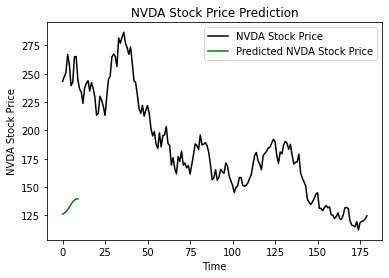

In [750]:
plt.plot(y_test, color = 'black', label = 'NVDA Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted NVDA Stock Price')
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price')
plt.legend()
plt.show()
